In [3]:
import torch
import datasets, networks, sampling, completion, evaluation
import matplotlib.pyplot as plt
from torch import nn

In [2]:
#HYPERPARAMETERS
num_epochs = 30

# TODO Select a optimizer. [ 'adam', 'adamw', 'rmsprop' ]
optimizer_option = 'adamw'

# TODO Select a lr scheduler. [ 'step', 'cosine', 'exponential']
lr_scheduler_option = ''

# TODO Select a batch size.
batch_size = 64

# TODO Select a learning rate.
lr = 0.00005


num_residual = 7
num_kernels = 96

In [3]:
ds = datasets.Dataset('cifar10', batch_size=batch_size)
training_data = ds.get_train_data_loader()
test_data = ds.get_test_data_loader()

# ds.visualize_dataset(training_data)

Files already downloaded and verified


Using device: cuda:0
Epoch:   1/ 30, Batch     1, Loss: 5.6267
Epoch:   1/ 30, Batch   101, Loss: 5.4844
Epoch:   1/ 30, Batch   201, Loss: 5.1563
Epoch:   1/ 30, Batch   301, Loss: 4.8818
Epoch:   1/ 30, Batch   401, Loss: 4.6906
Epoch:   1/ 30, Batch   501, Loss: 4.5572
Epoch:   1/ 30, Batch   601, Loss: 4.4694
Epoch:   1/ 30, Batch   701, Loss: 4.4014
-----------------------------------------
Epoch:   1 took 120.09s
Epoch:   1, Test Loss: 4.3122
-----------------------------------------


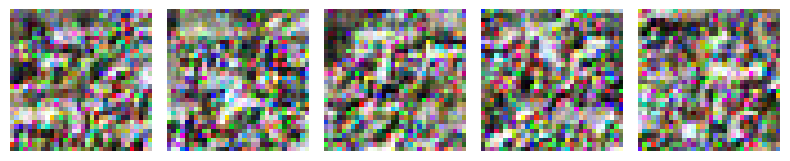

Epoch:   2/ 30, Batch     1, Loss: 4.3047
Epoch:   2/ 30, Batch   101, Loss: 4.3063
Epoch:   2/ 30, Batch   201, Loss: 4.2726
Epoch:   2/ 30, Batch   301, Loss: 4.2335
Epoch:   2/ 30, Batch   401, Loss: 4.2021
Epoch:   2/ 30, Batch   501, Loss: 4.1717
Epoch:   2/ 30, Batch   601, Loss: 4.1509
Epoch:   2/ 30, Batch   701, Loss: 4.1361
-----------------------------------------
Epoch:   2 took 120.10s
Epoch:   2, Test Loss: 4.1036
-----------------------------------------


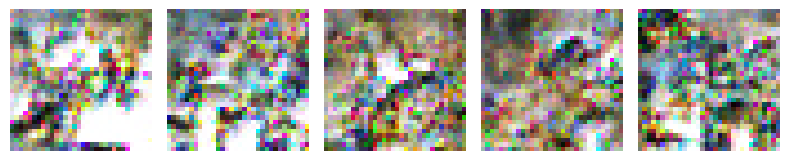

Epoch:   3/ 30, Batch     1, Loss: 4.1391
Epoch:   3/ 30, Batch   101, Loss: 4.0828
Epoch:   3/ 30, Batch   201, Loss: 4.0611
Epoch:   3/ 30, Batch   301, Loss: 4.0490
Epoch:   3/ 30, Batch   401, Loss: 4.0266
Epoch:   3/ 30, Batch   501, Loss: 4.0152
Epoch:   3/ 30, Batch   601, Loss: 4.0016
Epoch:   3/ 30, Batch   701, Loss: 3.9824
-----------------------------------------
Epoch:   3 took 121.44s
Epoch:   3, Test Loss: 3.9362
-----------------------------------------


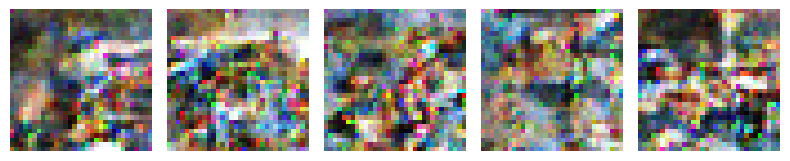

Epoch:   4/ 30, Batch     1, Loss: 3.9550
Epoch:   4/ 30, Batch   101, Loss: 3.9577
Epoch:   4/ 30, Batch   201, Loss: 3.9465
Epoch:   4/ 30, Batch   301, Loss: 3.9387
Epoch:   4/ 30, Batch   401, Loss: 3.9288
Epoch:   4/ 30, Batch   501, Loss: 3.9127
Epoch:   4/ 30, Batch   601, Loss: 3.9028
Epoch:   4/ 30, Batch   701, Loss: 3.9044
-----------------------------------------
Epoch:   4 took 116.27s
Epoch:   4, Test Loss: 3.8603
-----------------------------------------


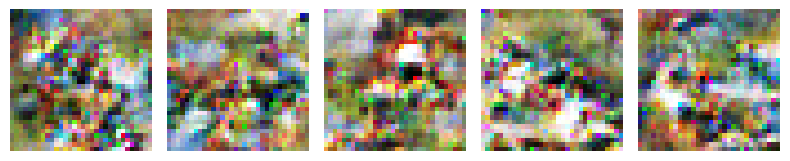

Epoch:   5/ 30, Batch     1, Loss: 3.8946
Epoch:   5/ 30, Batch   101, Loss: 3.8765
Epoch:   5/ 30, Batch   201, Loss: 3.8705
Epoch:   5/ 30, Batch   301, Loss: 3.8540
Epoch:   5/ 30, Batch   401, Loss: 3.8510
Epoch:   5/ 30, Batch   501, Loss: 3.8423
Epoch:   5/ 30, Batch   601, Loss: 3.8346
Epoch:   5/ 30, Batch   701, Loss: 3.8273
-----------------------------------------
Epoch:   5 took 116.24s
Epoch:   5, Test Loss: 3.8010
-----------------------------------------


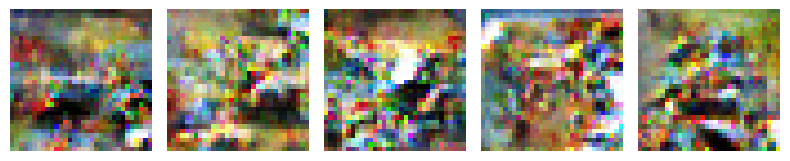

Epoch:   6/ 30, Batch     1, Loss: 3.8010
Epoch:   6/ 30, Batch   101, Loss: 3.8142
Epoch:   6/ 30, Batch   201, Loss: 3.8053
Epoch:   6/ 30, Batch   301, Loss: 3.8100
Epoch:   6/ 30, Batch   401, Loss: 3.7976
Epoch:   6/ 30, Batch   501, Loss: 3.7867
Epoch:   6/ 30, Batch   601, Loss: 3.7914
Epoch:   6/ 30, Batch   701, Loss: 3.7799
-----------------------------------------
Epoch:   6 took 114.91s
Epoch:   6, Test Loss: 3.7449
-----------------------------------------


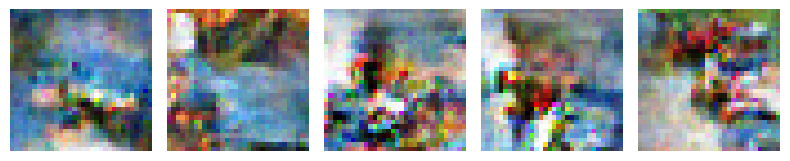

Epoch:   7/ 30, Batch     1, Loss: 3.7763
Epoch:   7/ 30, Batch   101, Loss: 3.7654
Epoch:   7/ 30, Batch   201, Loss: 3.7654
Epoch:   7/ 30, Batch   301, Loss: 3.7631
Epoch:   7/ 30, Batch   401, Loss: 3.7578
Epoch:   7/ 30, Batch   501, Loss: 3.7468
Epoch:   7/ 30, Batch   601, Loss: 3.7472
Epoch:   7/ 30, Batch   701, Loss: 3.7477
-----------------------------------------
Epoch:   7 took 114.18s
Epoch:   7, Test Loss: 3.7582
-----------------------------------------


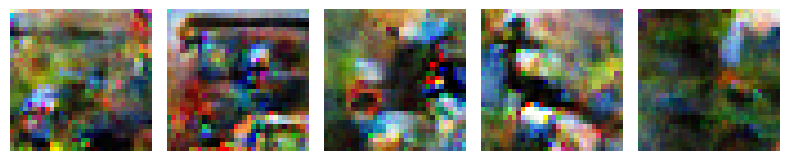

Epoch:   8/ 30, Batch     1, Loss: 3.7520
Epoch:   8/ 30, Batch   101, Loss: 3.7371
Epoch:   8/ 30, Batch   201, Loss: 3.7317
Epoch:   8/ 30, Batch   301, Loss: 3.7273
Epoch:   8/ 30, Batch   401, Loss: 3.7210
Epoch:   8/ 30, Batch   501, Loss: 3.7096
Epoch:   8/ 30, Batch   601, Loss: 3.7134
Epoch:   8/ 30, Batch   701, Loss: 3.7185
-----------------------------------------
Epoch:   8 took 114.14s
Epoch:   8, Test Loss: 3.7045
-----------------------------------------


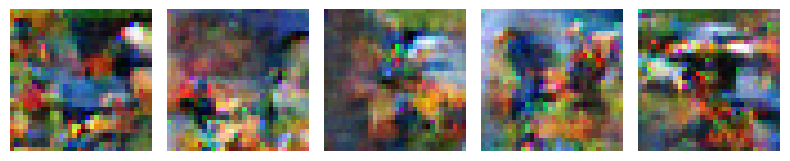

Epoch:   9/ 30, Batch     1, Loss: 3.6941
Epoch:   9/ 30, Batch   101, Loss: 3.6994
Epoch:   9/ 30, Batch   201, Loss: 3.7081
Epoch:   9/ 30, Batch   301, Loss: 3.6963
Epoch:   9/ 30, Batch   401, Loss: 3.7013
Epoch:   9/ 30, Batch   501, Loss: 3.6920
Epoch:   9/ 30, Batch   601, Loss: 3.6914
Epoch:   9/ 30, Batch   701, Loss: 3.6919
-----------------------------------------
Epoch:   9 took 114.12s
Epoch:   9, Test Loss: 3.6680
-----------------------------------------


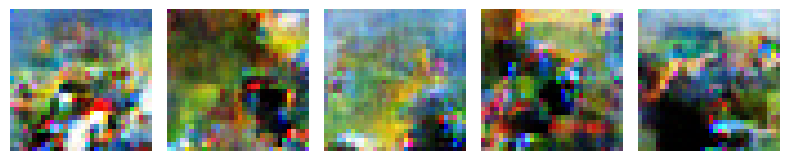

Epoch:  10/ 30, Batch     1, Loss: 3.7101
Epoch:  10/ 30, Batch   101, Loss: 3.6859
Epoch:  10/ 30, Batch   201, Loss: 3.6773
Epoch:  10/ 30, Batch   301, Loss: 3.6772
Epoch:  10/ 30, Batch   401, Loss: 3.6809
Epoch:  10/ 30, Batch   501, Loss: 3.6749
Epoch:  10/ 30, Batch   601, Loss: 3.6686
Epoch:  10/ 30, Batch   701, Loss: 3.6688
-----------------------------------------
Epoch:  10 took 114.09s
Epoch:  10, Test Loss: 3.6981
-----------------------------------------


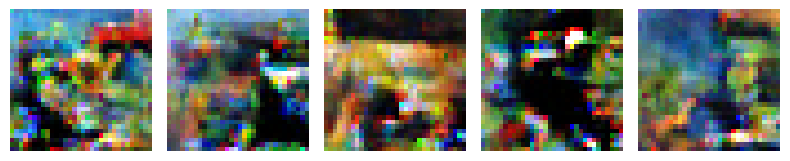

Epoch:  11/ 30, Batch     1, Loss: 3.7376
Epoch:  11/ 30, Batch   101, Loss: 3.6566
Epoch:  11/ 30, Batch   201, Loss: 3.6613
Epoch:  11/ 30, Batch   301, Loss: 3.6580
Epoch:  11/ 30, Batch   401, Loss: 3.6572
Epoch:  11/ 30, Batch   501, Loss: 3.6531
Epoch:  11/ 30, Batch   601, Loss: 3.6619
Epoch:  11/ 30, Batch   701, Loss: 3.6490
-----------------------------------------
Epoch:  11 took 116.67s
Epoch:  11, Test Loss: 3.6363
-----------------------------------------


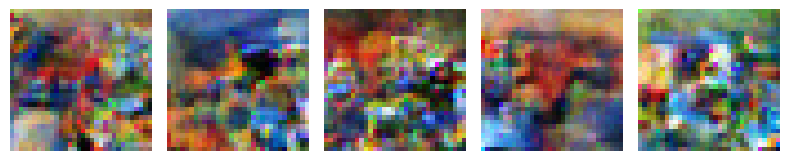

Epoch:  12/ 30, Batch     1, Loss: 3.6179
Epoch:  12/ 30, Batch   101, Loss: 3.6478
Epoch:  12/ 30, Batch   201, Loss: 3.6388
Epoch:  12/ 30, Batch   301, Loss: 3.6395
Epoch:  12/ 30, Batch   401, Loss: 3.6559
Epoch:  12/ 30, Batch   501, Loss: 3.6414
Epoch:  12/ 30, Batch   601, Loss: 3.6376
Epoch:  12/ 30, Batch   701, Loss: 3.6369
-----------------------------------------
Epoch:  12 took 131.35s
Epoch:  12, Test Loss: 3.6179
-----------------------------------------


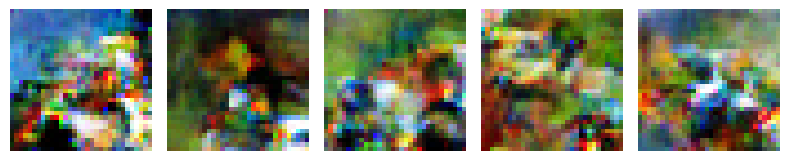

Epoch:  13/ 30, Batch     1, Loss: 3.5908
Epoch:  13/ 30, Batch   101, Loss: 3.6326
Epoch:  13/ 30, Batch   201, Loss: 3.6321
Epoch:  13/ 30, Batch   301, Loss: 3.6287
Epoch:  13/ 30, Batch   401, Loss: 3.6316
Epoch:  13/ 30, Batch   501, Loss: 3.6292
Epoch:  13/ 30, Batch   601, Loss: 3.6231
Epoch:  13/ 30, Batch   701, Loss: 3.6297
-----------------------------------------
Epoch:  13 took 131.05s
Epoch:  13, Test Loss: 3.5936
-----------------------------------------


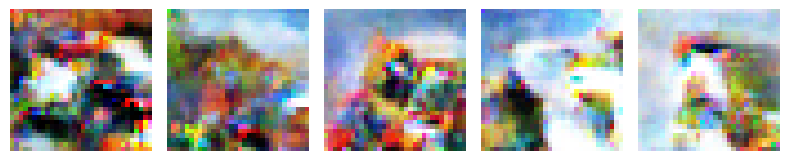

Epoch:  14/ 30, Batch     1, Loss: 3.5891
Epoch:  14/ 30, Batch   101, Loss: 3.6261
Epoch:  14/ 30, Batch   201, Loss: 3.6221
Epoch:  14/ 30, Batch   301, Loss: 3.6138
Epoch:  14/ 30, Batch   401, Loss: 3.6172
Epoch:  14/ 30, Batch   501, Loss: 3.6152
Epoch:  14/ 30, Batch   601, Loss: 3.6147
Epoch:  14/ 30, Batch   701, Loss: 3.6143
-----------------------------------------
Epoch:  14 took 132.23s
Epoch:  14, Test Loss: 3.5845
-----------------------------------------


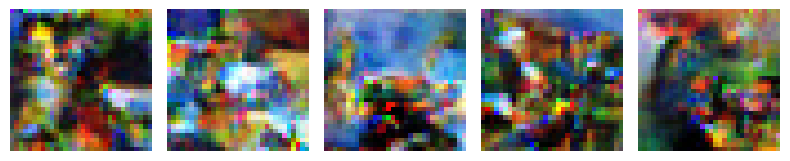

Epoch:  15/ 30, Batch     1, Loss: 3.5607
Epoch:  15/ 30, Batch   101, Loss: 3.6123
Epoch:  15/ 30, Batch   201, Loss: 3.6069
Epoch:  15/ 30, Batch   301, Loss: 3.6095
Epoch:  15/ 30, Batch   401, Loss: 3.6160
Epoch:  15/ 30, Batch   501, Loss: 3.6020
Epoch:  15/ 30, Batch   601, Loss: 3.6036
Epoch:  15/ 30, Batch   701, Loss: 3.5923
-----------------------------------------
Epoch:  15 took 132.21s
Epoch:  15, Test Loss: 3.5853
-----------------------------------------


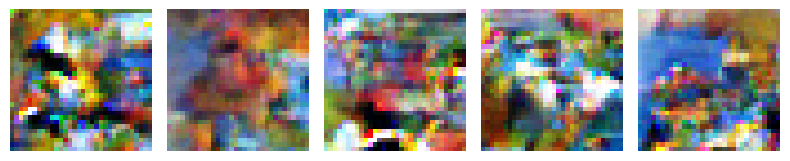

Epoch:  16/ 30, Batch     1, Loss: 3.6130
Epoch:  16/ 30, Batch   101, Loss: 3.6028
Epoch:  16/ 30, Batch   201, Loss: 3.5912
Epoch:  16/ 30, Batch   301, Loss: 3.6032
Epoch:  16/ 30, Batch   401, Loss: 3.5998
Epoch:  16/ 30, Batch   501, Loss: 3.5951
Epoch:  16/ 30, Batch   601, Loss: 3.5902
Epoch:  16/ 30, Batch   701, Loss: 3.5907
-----------------------------------------
Epoch:  16 took 125.38s
Epoch:  16, Test Loss: 3.5665
-----------------------------------------


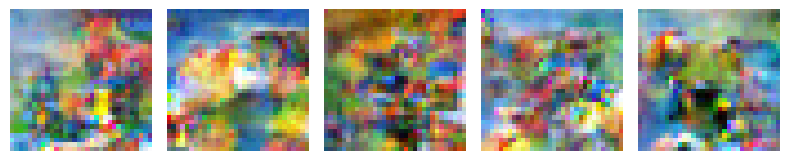

Epoch:  17/ 30, Batch     1, Loss: 3.5941
Epoch:  17/ 30, Batch   101, Loss: 3.5807
Epoch:  17/ 30, Batch   201, Loss: 3.5894
Epoch:  17/ 30, Batch   301, Loss: 3.5880
Epoch:  17/ 30, Batch   401, Loss: 3.5830
Epoch:  17/ 30, Batch   501, Loss: 3.5821
Epoch:  17/ 30, Batch   601, Loss: 3.5877
Epoch:  17/ 30, Batch   701, Loss: 3.5862
-----------------------------------------
Epoch:  17 took 123.19s
Epoch:  17, Test Loss: 3.5517
-----------------------------------------


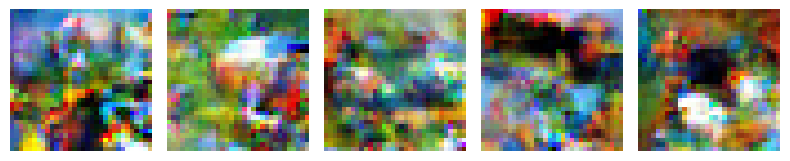

Epoch:  18/ 30, Batch     1, Loss: 3.5854
Epoch:  18/ 30, Batch   101, Loss: 3.5847
Epoch:  18/ 30, Batch   201, Loss: 3.5824
Epoch:  18/ 30, Batch   301, Loss: 3.5970
Epoch:  18/ 30, Batch   401, Loss: 3.5622
Epoch:  18/ 30, Batch   501, Loss: 3.5799
Epoch:  18/ 30, Batch   601, Loss: 3.5705
Epoch:  18/ 30, Batch   701, Loss: 3.5764
-----------------------------------------
Epoch:  18 took 116.43s
Epoch:  18, Test Loss: 3.5449
-----------------------------------------


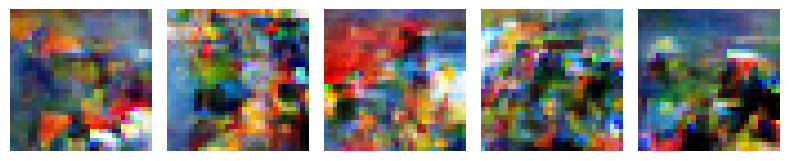

Epoch:  19/ 30, Batch     1, Loss: 3.5291
Epoch:  19/ 30, Batch   101, Loss: 3.5759
Epoch:  19/ 30, Batch   201, Loss: 3.5706
Epoch:  19/ 30, Batch   301, Loss: 3.5661
Epoch:  19/ 30, Batch   401, Loss: 3.5668
Epoch:  19/ 30, Batch   501, Loss: 3.5667
Epoch:  19/ 30, Batch   601, Loss: 3.5715
Epoch:  19/ 30, Batch   701, Loss: 3.5692
-----------------------------------------
Epoch:  19 took 122.60s
Epoch:  19, Test Loss: 3.5645
-----------------------------------------


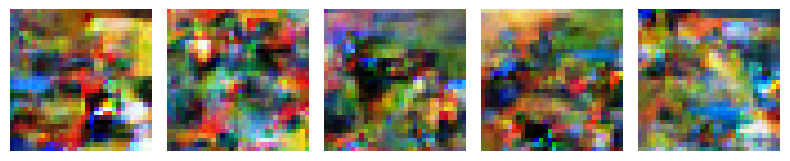

Epoch:  20/ 30, Batch     1, Loss: 3.5439
Epoch:  20/ 30, Batch   101, Loss: 3.5646
Epoch:  20/ 30, Batch   201, Loss: 3.5601
Epoch:  20/ 30, Batch   301, Loss: 3.5662
Epoch:  20/ 30, Batch   401, Loss: 3.5647
Epoch:  20/ 30, Batch   501, Loss: 3.5633
Epoch:  20/ 30, Batch   601, Loss: 3.5622
Epoch:  20/ 30, Batch   701, Loss: 3.5589
-----------------------------------------
Epoch:  20 took 122.13s
Epoch:  20, Test Loss: 3.5365
-----------------------------------------


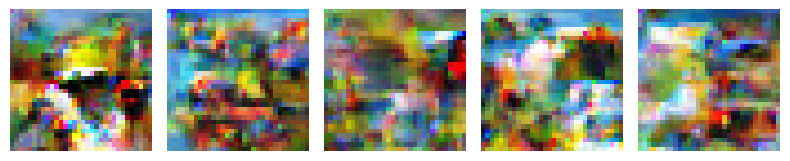

Epoch:  21/ 30, Batch     1, Loss: 3.5673
Epoch:  21/ 30, Batch   101, Loss: 3.5567
Epoch:  21/ 30, Batch   201, Loss: 3.5513
Epoch:  21/ 30, Batch   301, Loss: 3.5554
Epoch:  21/ 30, Batch   401, Loss: 3.5565
Epoch:  21/ 30, Batch   501, Loss: 3.5515
Epoch:  21/ 30, Batch   601, Loss: 3.5529
Epoch:  21/ 30, Batch   701, Loss: 3.5601
-----------------------------------------
Epoch:  21 took 121.90s
Epoch:  21, Test Loss: 3.5410
-----------------------------------------


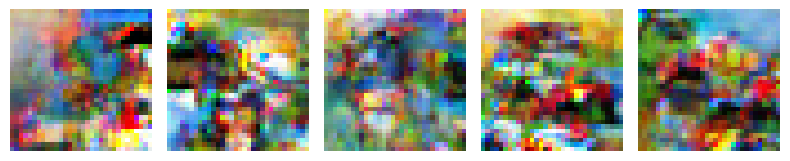

Epoch:  22/ 30, Batch     1, Loss: 3.6116
Epoch:  22/ 30, Batch   101, Loss: 3.5463
Epoch:  22/ 30, Batch   201, Loss: 3.5450
Epoch:  22/ 30, Batch   301, Loss: 3.5447
Epoch:  22/ 30, Batch   401, Loss: 3.5469
Epoch:  22/ 30, Batch   501, Loss: 3.5479
Epoch:  22/ 30, Batch   601, Loss: 3.5524
Epoch:  22/ 30, Batch   701, Loss: 3.5506
-----------------------------------------
Epoch:  22 took 121.46s
Epoch:  22, Test Loss: 3.5187
-----------------------------------------


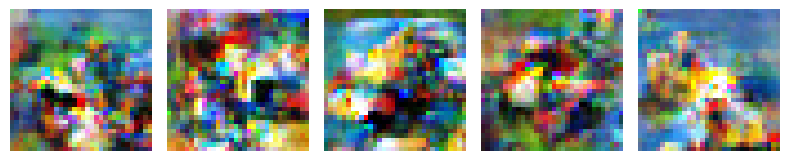

Epoch:  23/ 30, Batch     1, Loss: 3.5439
Epoch:  23/ 30, Batch   101, Loss: 3.5528
Epoch:  23/ 30, Batch   201, Loss: 3.5447
Epoch:  23/ 30, Batch   301, Loss: 3.5398
Epoch:  23/ 30, Batch   401, Loss: 3.5451
Epoch:  23/ 30, Batch   501, Loss: 3.5349
Epoch:  23/ 30, Batch   601, Loss: 3.5475
Epoch:  23/ 30, Batch   701, Loss: 3.5380
-----------------------------------------
Epoch:  23 took 117.79s
Epoch:  23, Test Loss: 3.5303
-----------------------------------------


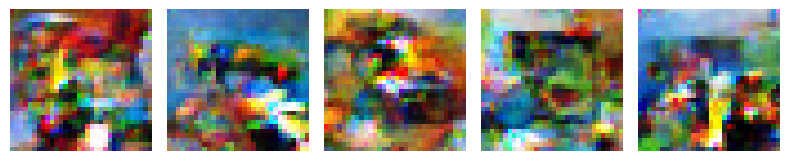

Epoch:  24/ 30, Batch     1, Loss: 3.5780
Epoch:  24/ 30, Batch   101, Loss: 3.5287
Epoch:  24/ 30, Batch   201, Loss: 3.5271
Epoch:  24/ 30, Batch   301, Loss: 3.5428
Epoch:  24/ 30, Batch   401, Loss: 3.5313
Epoch:  24/ 30, Batch   501, Loss: 3.5381
Epoch:  24/ 30, Batch   601, Loss: 3.5296
Epoch:  24/ 30, Batch   701, Loss: 3.5476
-----------------------------------------
Epoch:  24 took 121.09s
Epoch:  24, Test Loss: 3.5008
-----------------------------------------


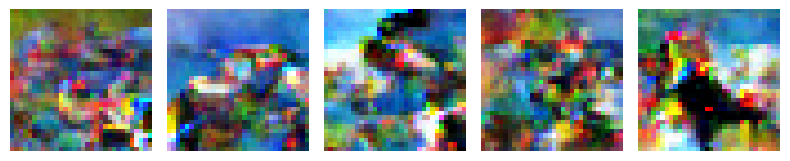

Epoch:  25/ 30, Batch     1, Loss: 3.5853
Epoch:  25/ 30, Batch   101, Loss: 3.5392
Epoch:  25/ 30, Batch   201, Loss: 3.5415
Epoch:  25/ 30, Batch   301, Loss: 3.5255
Epoch:  25/ 30, Batch   401, Loss: 3.5322
Epoch:  25/ 30, Batch   501, Loss: 3.5325
Epoch:  25/ 30, Batch   601, Loss: 3.5228
Epoch:  25/ 30, Batch   701, Loss: 3.5319
-----------------------------------------
Epoch:  25 took 138.41s
Epoch:  25, Test Loss: 3.5084
-----------------------------------------


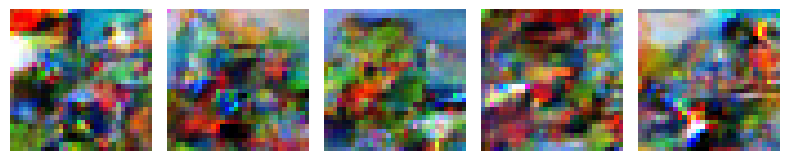

Epoch:  26/ 30, Batch     1, Loss: 3.5201
Epoch:  26/ 30, Batch   101, Loss: 3.5257
Epoch:  26/ 30, Batch   201, Loss: 3.5294
Epoch:  26/ 30, Batch   301, Loss: 3.5351
Epoch:  26/ 30, Batch   401, Loss: 3.5304
Epoch:  26/ 30, Batch   501, Loss: 3.5317
Epoch:  26/ 30, Batch   601, Loss: 3.5274
Epoch:  26/ 30, Batch   701, Loss: 3.5255
-----------------------------------------
Epoch:  26 took 138.25s
Epoch:  26, Test Loss: 3.5689
-----------------------------------------


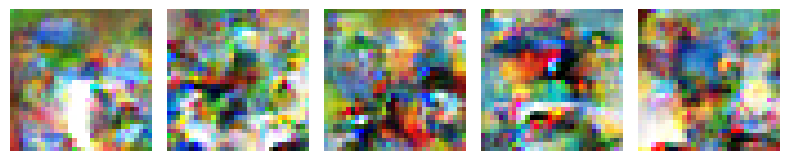

Epoch:  27/ 30, Batch     1, Loss: 3.5679
Epoch:  27/ 30, Batch   101, Loss: 3.5131
Epoch:  27/ 30, Batch   201, Loss: 3.5257
Epoch:  27/ 30, Batch   301, Loss: 3.5234
Epoch:  27/ 30, Batch   401, Loss: 3.5244
Epoch:  27/ 30, Batch   501, Loss: 3.5238
Epoch:  27/ 30, Batch   601, Loss: 3.5280
Epoch:  27/ 30, Batch   701, Loss: 3.5172
-----------------------------------------
Epoch:  27 took 136.98s
Epoch:  27, Test Loss: 3.5437
-----------------------------------------


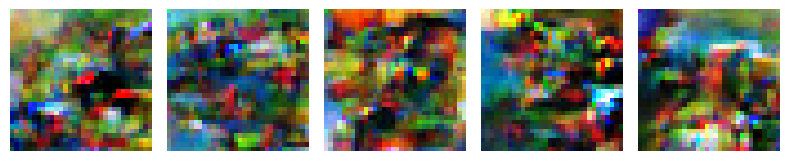

Epoch:  28/ 30, Batch     1, Loss: 3.4970
Epoch:  28/ 30, Batch   101, Loss: 3.5285
Epoch:  28/ 30, Batch   201, Loss: 3.5052
Epoch:  28/ 30, Batch   301, Loss: 3.5103
Epoch:  28/ 30, Batch   401, Loss: 3.5185
Epoch:  28/ 30, Batch   501, Loss: 3.5191
Epoch:  28/ 30, Batch   601, Loss: 3.5116
Epoch:  28/ 30, Batch   701, Loss: 3.5153
-----------------------------------------
Epoch:  28 took 133.11s
Epoch:  28, Test Loss: 3.4944
-----------------------------------------


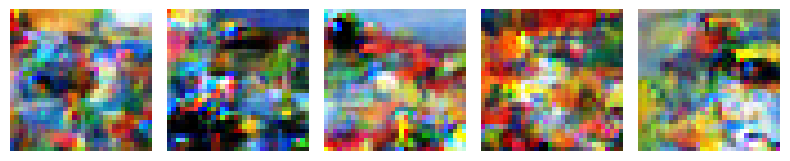

Epoch:  29/ 30, Batch     1, Loss: 3.4920
Epoch:  29/ 30, Batch   101, Loss: 3.5065
Epoch:  29/ 30, Batch   201, Loss: 3.5083
Epoch:  29/ 30, Batch   301, Loss: 3.5133
Epoch:  29/ 30, Batch   401, Loss: 3.5056
Epoch:  29/ 30, Batch   501, Loss: 3.5139
Epoch:  29/ 30, Batch   601, Loss: 3.5151
Epoch:  29/ 30, Batch   701, Loss: 3.5165
-----------------------------------------
Epoch:  29 took 131.79s
Epoch:  29, Test Loss: 3.4879
-----------------------------------------


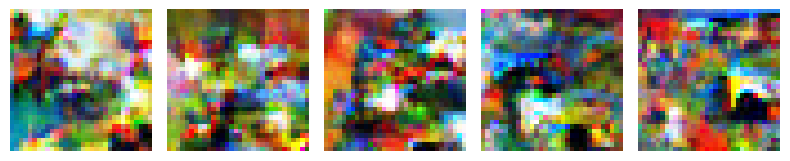

Epoch:  30/ 30, Batch     1, Loss: 3.5684
Epoch:  30/ 30, Batch   101, Loss: 3.5023
Epoch:  30/ 30, Batch   201, Loss: 3.5118
Epoch:  30/ 30, Batch   301, Loss: 3.5162
Epoch:  30/ 30, Batch   401, Loss: 3.5017
Epoch:  30/ 30, Batch   501, Loss: 3.5005
Epoch:  30/ 30, Batch   601, Loss: 3.5099
Epoch:  30/ 30, Batch   701, Loss: 3.5122
-----------------------------------------
Epoch:  30 took 133.25s
Epoch:  30, Test Loss: 3.4926
-----------------------------------------


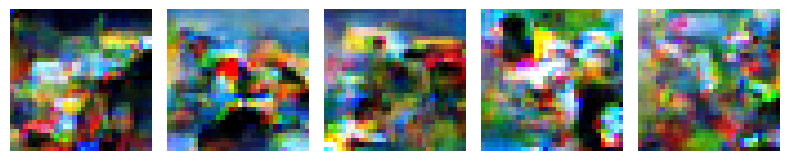

Training took 4448.78s


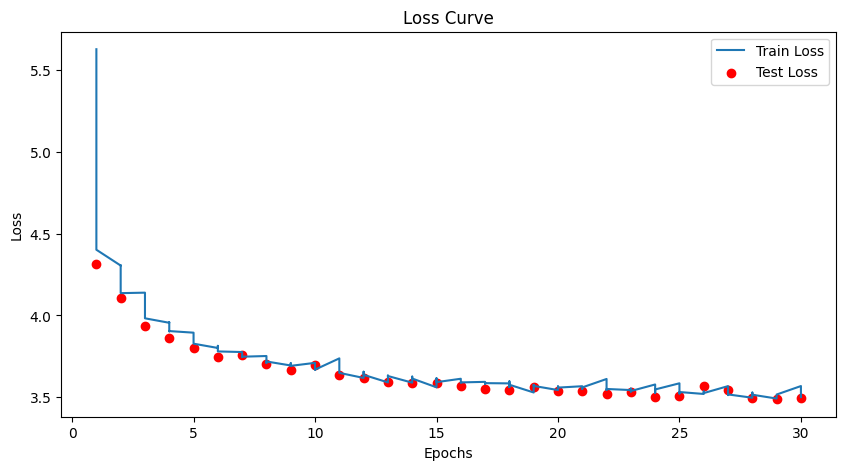

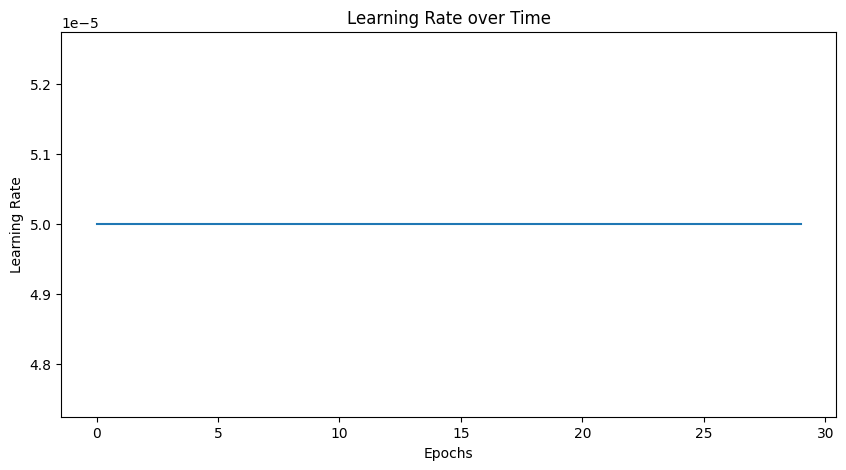

In [4]:
# Training
import time
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
from torch.optim import Adam, AdamW, RMSprop, SGD 

PixelCNN = networks.PixelCNN(num_kernels=num_kernels, num_residual=num_residual)
# Select device
# if torch.cuda.is_available():
#   device = torch.device('cuda:0')
# else:
#   device = torch.device('cpu')
device = torch.device('cuda:0')
print(f'Using device: {device}')
print('=========================================')

PixelCNN.to(device)

learning_rates = []
train_loss_curve = []
test_loss_curve = []
train_loss_epochs = []
test_loss_epochs = []
optimizer = None

# Select optimizer
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(PixelCNN.parameters(), lr)
  
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(PixelCNN.parameters(), lr)
  
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(PixelCNN.parameters(), lr)
  
else:
  optimizer = torch.optim.SGD(PixelCNN.parameters(), lr, momentum=0.9)  


#Select scheduler
scheduler = None
if lr_scheduler_option == 'step':
    scheduler = StepLR(optimizer, step_size=2, gamma=0.9)
    
elif lr_scheduler_option == 'exponential':
    scheduler = ExponentialLR(optimizer, gamma=0.9)
    
elif lr_scheduler_option == 'cosine':
    scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

overall_start_time = time.time()

# training loop
for epoch in range(num_epochs):

  epoch_start_time = time.time()
  # Switch to training mode.
  PixelCNN.train()

  losses = []
  batch_idx = 0

  for images, labels in training_data:

    images = images.to(device)
    output = PixelCNN(images)
    # print(output.shape)
    images = images.view(-1)
    # images = images.permute(0, 2, 3, 1).contiguous().view(-1)
    # print(images.shape)
    output = torch.reshape(output, (batch_size, 256, 3, 32, 32))
    output = output.permute(0,2,3,4,1).contiguous().view(-1, 256)

    # output = nn.functional.softmax(output, dim=1)
    # output = torch.argmax(output, dim=1)

    # print(output)
    images = images*255
    # print(images.long())

    loss = nn.functional.cross_entropy(output, images.long())
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(PixelCNN.parameters(), 1)
    optimizer.step()
    for param_group in optimizer.param_groups:
      learning_rates.append(param_group['lr'])
    optimizer.zero_grad()


    losses.append(loss.detach().clone())

    if batch_idx % 100 == 0:
      average_loss = torch.stack(losses).mean().item()
      train_loss_curve.append(average_loss)
      train_loss_epochs.append(epoch + 1)
      losses = []
      print(f'Epoch: {epoch + 1:3d}/{num_epochs:3d}, Batch {batch_idx + 1:5d}, Loss: {average_loss:.4f}')
    batch_idx += 1

  # scheduler.step()
  epoch_end_time = time.time()
  print('-----------------------------------------')
  print(f'Epoch: {epoch + 1:3d} took {epoch_end_time - epoch_start_time:.2f}s')
  test_loss = evaluation.evaluate(model=PixelCNN, test_data_loader=test_data, device=device, batch_size=batch_size)
  test_loss_curve.append(test_loss)
  test_loss_epochs.append(epoch + 1)
  print(f'Epoch: {epoch + 1:3d}, Test Loss: {test_loss:.4f}')
  print('-----------------------------------------')
  

  samples = sampling.sample(PixelCNN, num_samples=5)
  sampling.save_samples(samples)
  

overall_end_time = time.time()
print('=========================================')
print(f'Training took {overall_end_time - overall_start_time:.2f}s')

# Loss Curve Plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss_epochs, train_loss_curve, label='Train Loss')
plt.scatter(test_loss_epochs, test_loss_curve, color='red', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Learning Rate Plot
num_batches = len(training_data)
learning_rates_res = [sum(learning_rates[i * num_batches:(i + 1) * num_batches]) / num_batches for i in range(num_epochs)]
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), learning_rates_res)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Time')
plt.show()